In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
train_dir = '../data/raw/asl_alphabet_train/asl_alphabet_train'
test_dir = '../data/raw/asl_alphabet_test/asl_alphabet_test'

img_height = 64
img_width = 64
batch_size = 32

In [ ]:
import os
import shutil

test_dir = '../data/raw/asl_alphabet_test/asl_alphabet_test'

for filename in os.listdir(test_dir):
    if filename.endswith('.jpg'):
        class_name = filename.split('_')[0]

        class_folder = os.path.join(test_dir, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

        old_path = os.path.join(test_dir, filename)
        new_path = os.path.join(class_folder, filename)
        shutil.move(old_path, new_path)

print("✅ Test images have been rearranged into class folders!")


✅ Test images have been rearranged into class folders!


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Found 28 images belonging to 28 classes.


In [5]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

c:\Users\CHPde\OneDrive\Bureau\Projects\Sign Language Project\ADS-Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10


c:\Users\CHPde\OneDrive\Bureau\Projects\Sign Language Project\ADS-Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 99s 45ms/step - accuracy: 0.4203 - loss: 1.9476 - val_accuracy: 0.7310 - val_loss: 0.8668
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 90s 42ms/step - accuracy: 0.8904 - loss: 0.3122 - val_accuracy: 0.7895 - val_loss: 0.7755
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 106s 49ms/step - accuracy: 0.9421 - loss: 0.1658 - val_accuracy: 0.8140 - val_loss: 0.7678
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 92s 42ms/step - accuracy: 0.9621 - loss: 0.1098 - val_accuracy: 0.8176 - val_loss: 0.8370
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 112s 51ms/step - accuracy: 0.9703 - loss: 0.0871 - val_accuracy: 0.8394 - val_loss: 0.7119
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 104s 48ms/step - accuracy: 0.9752 - loss: 0.0727 - val_accuracy: 0.8377 - val_loss: 0.7256
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 118s 54ms/step - accuracy: 0.9801 - loss: 0.0586 - val_accuracy: 0.8389 - val_loss: 0.7725
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 100s 46ms/step - accuracy: 0.9814 - loss:

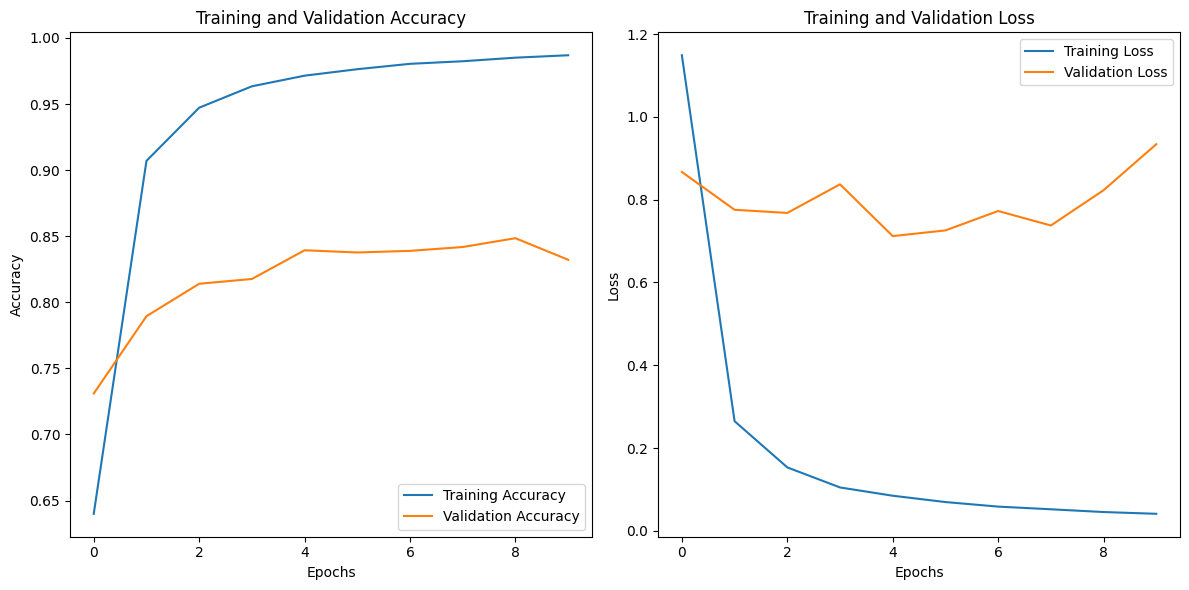

In [7]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()